In [1]:
#Sebastian Russo 79117092
#Bachelor Thesis
#Application of Machine Learning Techniques for the Early Detection of Diabetes: 
#A Comparative Study of Classification Models

#Library to manipulate and analyze datasets 
import pandas as pd
import numpy as np

#open-source machine learning library with models and metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle

#Library for handling imbalanced datasets in machine learning
from imblearn.over_sampling import SMOTE

#Library for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For path finding
from pathlib import Path

#Logging 
import logging

#Time
import time

In [2]:
#Ensure the log directory exists to save logs
log_name = "decision_tree_model.log"
log_dir = Path("logs")
log_dir.mkdir(exist_ok=True)

#Create logger
log_handler = logging.getLogger("my_logger")
log_handler.setLevel(logging.INFO) 

#Create file handler
file_handler = logging.FileHandler(log_dir / log_name, mode='w')
file_handler.setLevel(logging.INFO)
#Create console (stream) handler
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

#Create formatter and add to file handler
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')
file_handler.setFormatter(formatter)
#Add the file handler to your logger
log_handler.addHandler(file_handler)

log_handler.info("Log handler successfully set")
log_handler.info(f"All logs are being saved in {log_name}")

In [3]:
#Construct path using pathlib
data_path = Path("dataset") / "diabetes_binary_health_indicators_BRFSS2015.csv"
dataset_df = pd.read_csv(data_path)
log_handler.info("Dataset successfully found and loaded")

In [4]:
#Parameters
test_size = 0.25 #data is divided 25% test and 75% train
random_state = 42 #Seed for reproducibility
class_weight = "balanced" #Adjusts weights inversely to class frequencies
max_depth = 16 #Maximum depth of each tree. The deeper the more accurate but complex and overfits

log_handler.info(f"Parameters set")

In [5]:
#Handle missing values
if dataset_df.isnull().sum().any():
    imputer = SimpleImputer(strategy="mean")  # or median/mode
    dataset_df.iloc[:, :] = imputer.fit_transform(dataset_df)
    log_handler.info("Missing values detected and imputed using SimpleImputer with mean strategy.")
else:
    log_handler.info("No missing values found; imputation not needed.")

#Remove duplicate values
initial_count = len(dataset_df)
dataset_df.drop_duplicates(inplace=True)
duplicates_removed = initial_count - len(dataset_df)

if duplicates_removed > 0:
    log_handler.info(f"Removed {duplicates_removed} duplicate rows from the dataset.")
else:
    log_handler.info("No duplicate rows found; no rows removed.")

#Encode ordinal features (if any)
#We can safely assume there is no categorical ordinal features are present.

In [6]:
#Split data between dependent and independent
independent_variable = dataset_df.drop(columns=['Diabetes_binary'])  
dependent_variable = dataset_df['Diabetes_binary']
log_handler.info(f"Independent variables shape {independent_variable.shape}")
log_handler.info(f"Dependent variables shape {dependent_variable.shape}")

#Split dependent and independent into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    independent_variable, dependent_variable, 
    test_size=test_size,
    stratify=dependent_variable, #data consistency
    random_state=random_state #Ensure splits are reproducible
) 
log_handler.info(f"X_train shape {X_train.shape} and X_text shape {X_test.shape}")
log_handler.info(f"Y_train shape {Y_train.shape} and Y_text shape {Y_test.shape}")

In [7]:
#Handle class imbalance
smote = SMOTE(random_state=random_state)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
log_handler.info("Applied SMOTE. "
                "Class distribution after resampling: "
                f"{dict(pd.Series(Y_train_resampled).value_counts())}")

#Feature scaling
# Note: Scaling is NOT necessary for Decision Trees, so we skip StandardScaler and use resampled
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_resampled)
# X_test_scaled = scaler.transform(X_test)
# log_handler.info("Feature scaling applied using StandardScaler to training and test sets.")

#Data shuffle on training set
X_train_resampled, Y_train_resampled = shuffle(X_train_resampled, Y_train_resampled, 
                                            random_state=random_state)
log_handler.info("Shuffled the training data after resampling")


In [8]:
#Train decision tree model
start__train_time = time.time()  #Start timer
decision_tree_classifier = DecisionTreeClassifier(class_weight=class_weight, 
                                                max_depth=max_depth, 
                                                random_state=random_state)
decision_tree_classifier.fit(X_train_resampled, Y_train_resampled)
end_train_time = time.time()  #End timer

log_handler.info("Trained Decision Tree model with "
                f"class_weight='{class_weight}' and max_depth={max_depth}")

training_duration = end_train_time - start__train_time #Get full training time
log_handler.info(f"Model training completed in {training_duration:.4f} seconds.")


In [9]:
#Predictions
predicted_Y = decision_tree_classifier.predict(X_test)
Y_probability = decision_tree_classifier.predict_proba(X_test)[:, 1]

comparison_df = pd.DataFrame({
    'Actual': Y_test.values[:30],
    'Predicted': predicted_Y[:30],
    'Probability_Class_1': Y_probability[:30]
})
log_handler.info(f"Comparison:\n{comparison_df}")

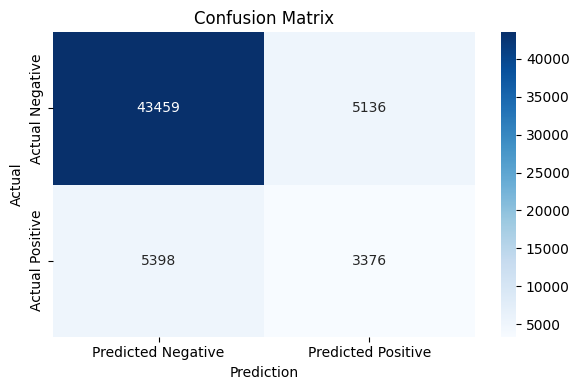

In [10]:
#Model evaluation
#Calculate and log evaluation metrics
accuracy = accuracy_score(Y_test, predicted_Y)
precision = precision_score(Y_test, predicted_Y)
recall = recall_score(Y_test, predicted_Y)
f1 = f1_score(Y_test, predicted_Y)
roc_auc = roc_auc_score(Y_test, Y_probability)
report = classification_report(Y_test, predicted_Y)
#Logs
log_handler.info("Model evaluation metrics:")
log_handler.info(f"Accuracy: {accuracy:.4f}")
log_handler.info(f"Precision: {precision:.4f}")
log_handler.info(f"Recall: {recall:.4f}")
log_handler.info(f"F1 Score: {f1:.4f}")
log_handler.info(f"ROC AUC: {roc_auc:.4f}")
log_handler.info("Classification Report:\n" + report)

#Confusion Matrix
cm = confusion_matrix(Y_test, predicted_Y)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
log_handler.info(f"Confusion matrix:\n{cm}")

#Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_scores = cross_val_score(decision_tree_classifier, X_train_resampled, Y_train_resampled, 
                            cv=cv, scoring='f1')
log_handler.info(f"5-Fold Cross-Validation F1 Scores: {cv_scores}")
log_handler.info(f"Average Cross-Validation F1 Score: {np.mean(cv_scores):.4f}")


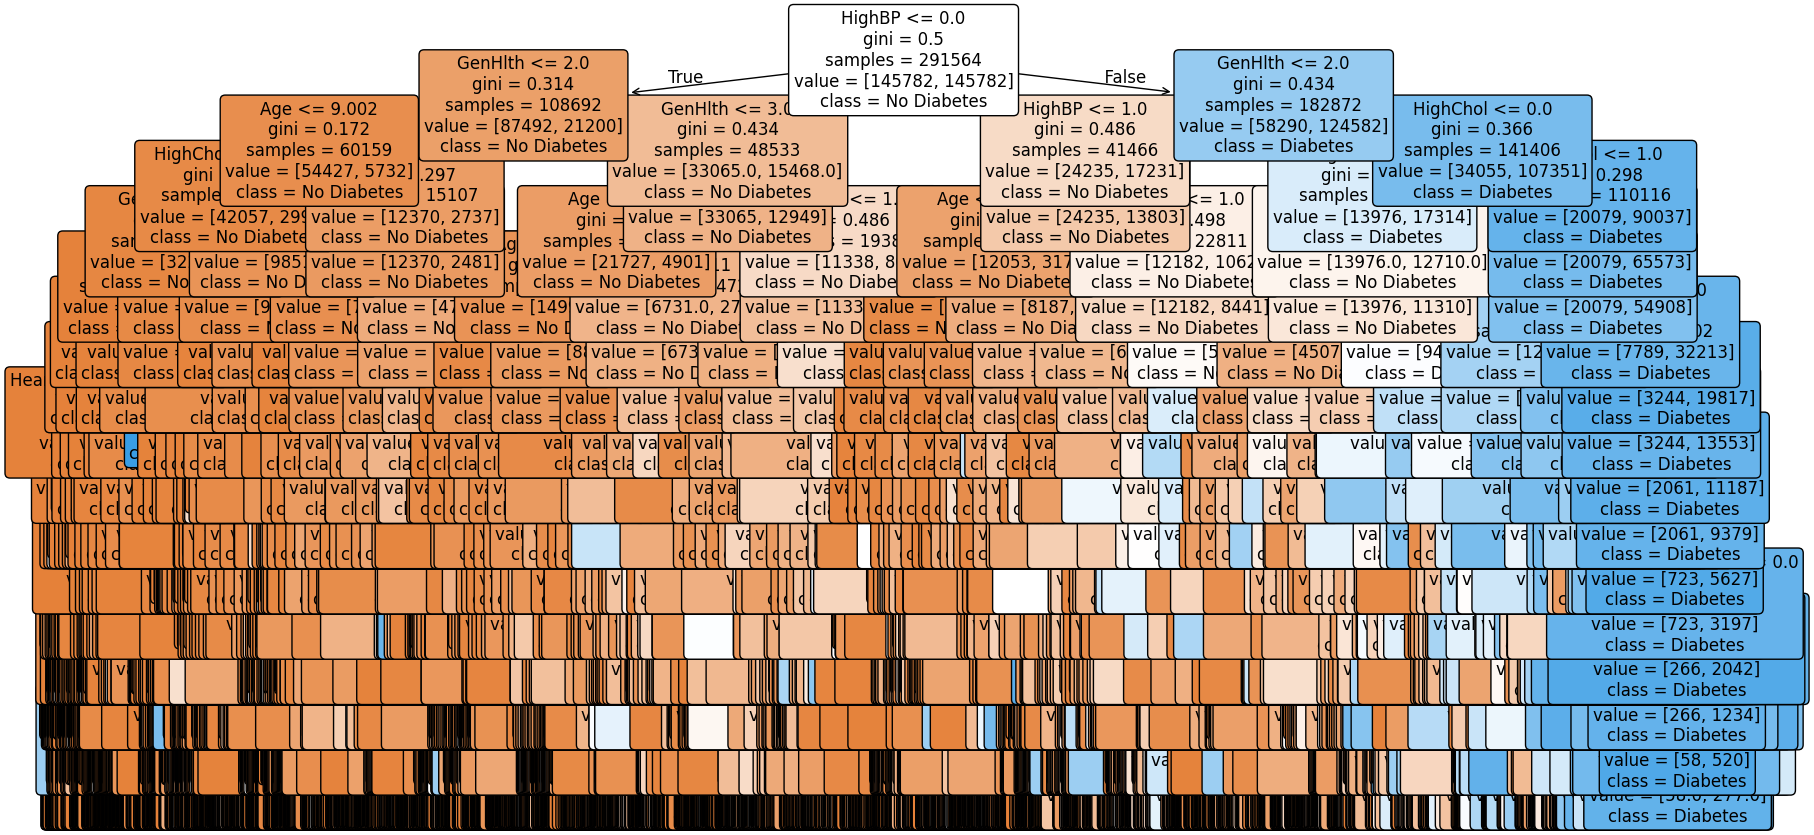

In [11]:
#Visualize Decision Tree
features = list(independent_variable.columns)
classes = ['No Diabetes', 'Diabetes']

plt.figure(figsize=(20, 10))
tree.plot_tree(
    decision_tree_classifier,
    feature_names=features,
    class_names=classes,
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree Visualization")
plt.show()